## Non-contextualized model

Let's train a model without using the news

In [1]:
%load_ext autoreload
%autoreload 2
import os
from hatedetection import load_datasets

train_dataset, dev_dataset, test_dataset = load_datasets()

#train_dataset = train_dataset.select(range(500))

Let's take just the comments

It seems that somehow it is evenly distributed...

In [2]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer

model_name = '../models/bert-non-contextualized-hate-speech-es/'

model = BertForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=2)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

model.eval();



tokenizer = BertTokenizer.from_pretrained(model_name)
tokenizer.model_max_length = 128

In [3]:
def tokenize(batch, context=True, padding='max_length', truncation=True):
    """
    Apply tokenization
    
    Arguments:
    ---------
    
    use_context: boolean (default True)
        Whether to add the context to the 
    """
    
    if context:
        args = [batch['context'], batch['text']]
    else:
        args = [batch['text']]
        
    return tokenizer(*args, padding='max_length', truncation=True)

batch_size = 32
eval_batch_size = 16

my_tokenize = lambda x: tokenize(x, context=False)

train_dataset = train_dataset.map(my_tokenize, batched=True, batch_size=batch_size)
dev_dataset = dev_dataset.map(my_tokenize, batched=True, batch_size=eval_batch_size)
test_dataset = test_dataset.map(my_tokenize, batched=True, batch_size=eval_batch_size)



In [4]:

def format_dataset(dataset):
    dataset = dataset.map(lambda examples: {'labels': examples['HATEFUL']})
    dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
    return dataset

train_dataset = format_dataset(train_dataset)
dev_dataset = format_dataset(dev_dataset)
test_dataset = format_dataset(test_dataset)

In [5]:
from hatedetection.metrics import compute_hate_metrics
from transformers import Trainer, TrainingArguments


training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=eval_batch_size,
    evaluation_strategy="epoch",
    do_eval=False,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

results = []

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_hate_metrics,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
)


In [6]:
import pandas as pd
pd.options.display.max_columns = 40
pd.set_option('display.float_format', lambda x: '%.5f' % x)

df_results = pd.DataFrame([trainer.evaluate(dev_dataset)])

df_results.T

,0
eval_loss,0.77142
eval_accuracy,0.90424
eval_f1,0.80209
eval_precision,0.82527
eval_recall,0.78353
eval_runtime,37.39010
eval_samples_per_second,243.54000
init_mem_cpu_alloc_delta,54747.00000
init_mem_gpu_alloc_delta,0.00000
init_mem_cpu_peaked_delta,18258.00000


## Error Analysis

In [7]:
pred_output = trainer.predict(dev_dataset)

pred_output

PredictionOutput(predictions=array([[ 4.7449136, -5.025515 ],
       [ 4.9441338, -5.10354  ],
       [ 4.7919507, -5.047395 ],
       ...,
       [ 4.862224 , -5.1078835],
       [ 4.9245434, -5.13089  ],
       [ 2.4692338, -2.6438978]], dtype=float32), label_ids=array([0, 0, 0, ..., 0, 0, 0]), metrics={'eval_loss': 0.7714242339134216, 'eval_accuracy': 0.9042389633208874, 'eval_f1': 0.8020902124428535, 'eval_precision': 0.8252730022278221, 'eval_recall': 0.7835341645671927, 'eval_runtime': 37.9583, 'eval_samples_per_second': 239.895, 'test_mem_cpu_alloc_delta': 208852, 'test_mem_gpu_alloc_delta': 0, 'test_mem_cpu_peaked_delta': 756498, 'test_mem_gpu_peaked_delta': 69447680})

In [8]:
from datasets import ClassLabel
from hatedetection import extended_hate_categories


dev_df = dev_dataset.to_pandas()
PAD_IDX = tokenizer.vocab["[PAD]"]

def decode(example):
    """
    Returns what the BERT models get as input
    """
    input_ids = [x.item() for x in example["input_ids"] if x.item() != PAD_IDX]
    return tokenizer.decode(input_ids)




dev_df["tokenized_text"] = dev_df.apply(decode, axis=1)
dev_df = dev_df[["text", "context", "tokenized_text", "labels"] + extended_hate_categories]

dev_df["predicted"] = pred_output.predictions.argmax(axis=1)

<AxesSubplot:ylabel='index'>

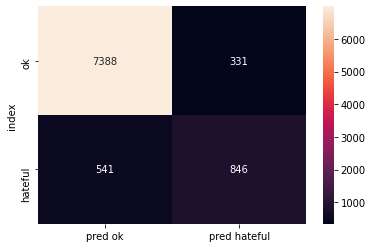

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(
    confusion_matrix(dev_df["labels"], dev_df["predicted"])
)

cm.columns = ["pred ok", "pred hateful"]

cm["index"] = ["ok", "hateful"]

cm.set_index("index", inplace=True)

normalized = cm
#normalized = (cm - cm.mean(axis=0)) / cm.std(axis=0)
sns.heatmap(normalized, annot=cm, fmt="", robust=True)

## Errors

In [10]:
false_negatives = dev_df.loc[((~dev_df["predicted"]) & (dev_df["labels"])) != 0]

false_positives = dev_df.loc[((dev_df["predicted"]) & (~dev_df["labels"])) != 0]

columns = ["text", "context", "tokenized_text"] + extended_hate_categories
false_negatives = false_negatives[columns]
false_positives = false_positives[columns]

In [22]:
from hatedetection.predict import predict_hateful

def predict(sentence, context=None):
    return predict_hateful(model, tokenizer, sentence, context=context)

In [87]:
predict("""Si, claro. Tengo gente muy amiga en la agrupación Putos Peronistas.
Porque la Justicia Social se construye sin discriminación.""")

False

In [100]:
predict("""putos horribles""")

True

In [29]:
predict("Gracias")

False

In [26]:
predict("Gracias negro")

True

In [21]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element